# Определение закономерности успешности игр

**Содержание**

1. [Изучение данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Замена типа данных](#type)
    * [Обработка дубликатов](#dup)
    * [Суммарные продажи во всех регионах](#sum_reg)
3. [Анализ данных](#analysis)
    * [Сколько игр выпускалось в разные годы](*games_years)
    * [Продажи игр по платформам](*sales_plt)
    * [Выбор актуального периода](*actual_prd)
    * [Какие платформы лидируют по продажам, растут или падают](*platform_grow)
    * [Глобальные продажи по платформам](*global_platform)
    * [Влияние отзывов пользователей и критиков на продажи в рамках платформы](*critics_plt)
    * [Распределение игр по жанрам](*genres)
4. [Портрет пользователя каждого региона](*portrait)
    * [Самые популярные платформы по регионам (топ-5)](*pop_plt5)
    * [Самые популярные жанры по регионам (топ-5)](*pop_genre5)
    * [Влияет ли рейтинг ESRB на продажи по регионам](*ESRB)
5. [Проверка гипотез](*hypothesis)
    * [Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](*XONEPC)
    * [Средние пользовательские рейтинги жанров Action и Sports одинаковые](*ACSP)
    * [Общий вывод](*conc)

## Изучение данных <a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Вывод**

Представлены данные по выпущенным играм за период с 1980 по 2016 год для разных игровых платформ.

У игр присвоена платформа, на которой игра выходила, год выпуска, жанр, рейтинг, количество продаж в разных регионах, а также рейтинг критиков и пользователей.

## Предобработка данных <a id="preprocessing"></a>

### Замена типа данных <a id="type"></a>

In [5]:
df.columns = df.columns.str.lower() # перевод названий столбцов в нижний регистр

In [6]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')
df['year_of_release'] = pd.DatetimeIndex(df['year_of_release']).year

df.genre = df.genre.astype('category')
df.rating = df.rating.astype('category')

In [7]:
df['user_score'].value_counts().head()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
Name: user_score, dtype: int64

In [8]:
df[df['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


In [9]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)

In [10]:
df.user_score = df.user_score.astype('float32')

**Вывод**

Наименования столбцов переведены в нижний регистр.

Столбец year_of_release указывает год выпуска, переведен в формат даты, после в формат года, так как указан только год (без месяца и дня).

Столбцы жанра и рейтинга переведены в формат категории для более быстрой обработки.

Столбец user_score показывает рейтинг пользователей и изначально был в формате object. Присутствовали значения 'tbd', который означает, что рейтинг отсутствует и появится позже. Такие значения можно заменить на пропуски, а столбец перевести в числовой формат.

### Обработка пропусков <a id="skip"></a>

In [11]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [12]:
df.dropna(subset = ['name','year_of_release'], inplace = True)

In [13]:
df['rating'] = df['rating'].cat.add_categories('without rating')
df['rating'] = df['rating'].fillna('without rating')

Так как столбец переведен в формат category новое значение создается как категория и присваивается после.

**Вывод**

Пропуски в столбцах name и year_of_release невозможно заполнить адекватно, такие строки удалены.

Пропуски в столбцах critic_score и user_score показывает, что данным играм оценка не была выставлена.

Пропуски в столбце rating указывает, что этим играм рейтинг не был присвоен ассоциацией, пропуски заменены на "без рейтинга".

### Обработка дубликатов <a id="dup"></a>

In [14]:
df.duplicated().sum()

0

**Вывод**

Дубликатов не обнаружено.

### Суммарные продажи во всех регионах <a id="sum_reg"></a>

In [15]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,without rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,without rating,31.38


**Вывод**

Значения добавлены.

## Анализ данных <a id="analysis"></a>

### Сколько игр выпускалось в разные годы <a id="games_years"></a>

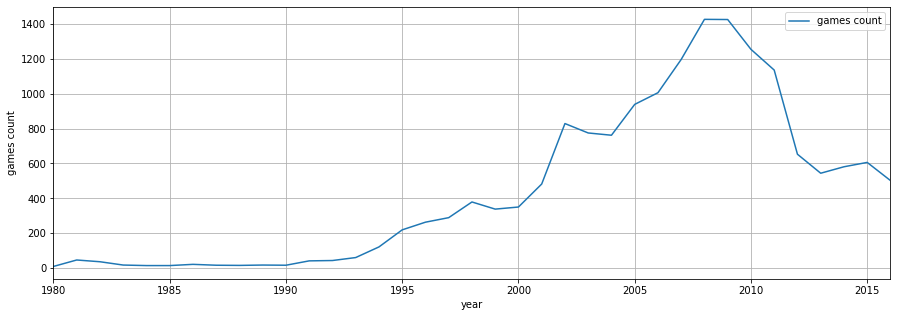

In [16]:
df.groupby(['year_of_release']).agg({'name':'count'}).plot(y='name', figsize=(15, 5), grid=True)
plt.legend(["games count"])
plt.xlabel('year')
plt.ylabel('games count')
plt.xticks(np.arange(1980,2016,5))
plt.show()

**Вывод**

С 1980 года присутствует рост числа выпущенных в год игр. Больше всего игр выпускалось в 2008 и 2009 годах, более 1400 в год. В 2015 году было выпущено 600 игр.

### Продажи игр по платформам <a id="sales_plt"></a>

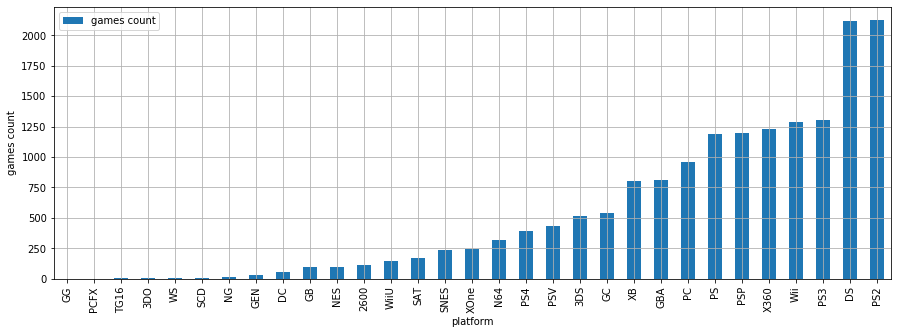

In [17]:
df.groupby(['platform']).agg({'name':'count'}).sort_values(by = 'name'\
                                                          ).plot(y='name', kind='bar', figsize=(15, 5), grid=True)
plt.legend(["games count"])
plt.xlabel('platform')
plt.ylabel('games count')
plt.show()

In [18]:
platform_by_year_all = df.pivot_table(index = ['year_of_release'], columns = 'platform', values = 'name', aggfunc = 'count'\
                                 ).rename_axis(None, axis=1)

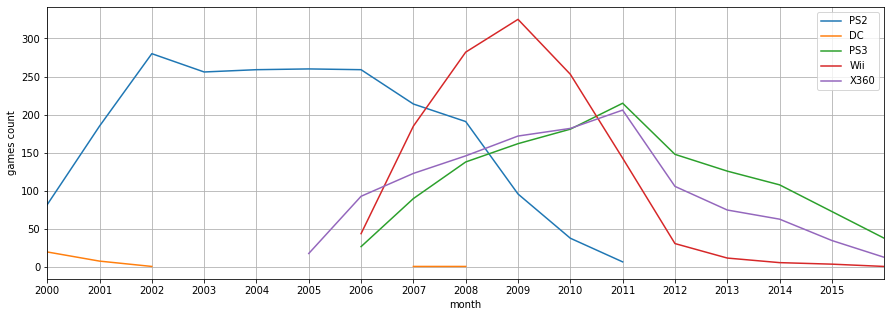

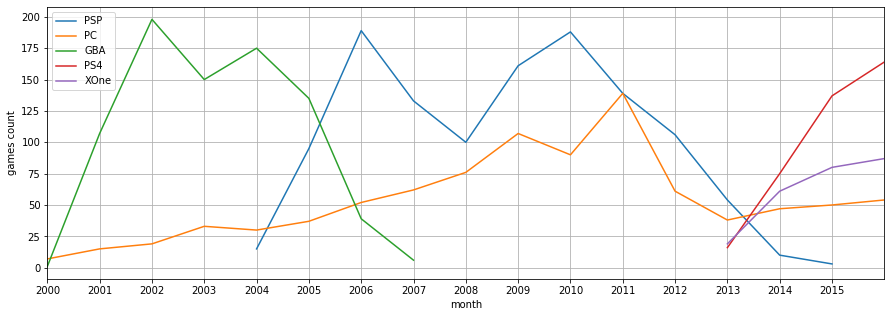

In [19]:
platform_by_year_all[["PS2", "DC", "PS3", "Wii", "X360"]\
                    ].plot(figsize=(15, 5), grid=True)
plt.xlim(2000, 2016)
plt.xticks(range(2000, 2016))
plt.xlabel('month')
plt.ylabel('games count')
platform_by_year_all[["PSP", "PC", "GBA", "PS4", "XOne"]\
                    ].plot(figsize=(15, 5), grid=True)
plt.xlim(2000, 2016)
plt.xticks(range(2000, 2016))
plt.xlabel('month')
plt.ylabel('games count')
plt.show()

**Вывод**

Больше всего было выпущено игр для PS2 и DS, более 2000 тайтлов, но данные консоли были в активном использовании до 2011 года - PS2 и 2002 года DS. Это значит, что они более не актуальны. Игры для портативной консоли PSP выходили с 2004 по 2015 год.

Выделяется график для выпуска игр на PC (персональный компьютер). Компьютеры, в отличие от консолей не имеют четкой версионности и несмотря на растущие требования игр с точки зрения комплектующих для ПК игры маркируются общими системными требованиями.

На графике видно, что игры для PS2 выпускались до 2011, в то время как игры для PS3 стали выпускаться с 2006 года и выпускаются до сих пор. Такая же ситуация со старой версией Xbox 360 и и новой Xbox One. Это показывает, что несмотря на выход новой версии консоли старая пользуется спросом еще примерно 5 лет. Средний срок жизни консоли - 11 лет.

С 2013 года начинают выходить игры для следующей версии Playstation - PS4 и на текущий момент выпуск числа игр растет. Такая же ситуация с новой моделью Xbox - Xbox One, которая также вышла в 2013 году.

### Выбор актуального периода <a id="actual_prd"></a>

In [20]:
df_actual = df.query('year_of_release > 2010').reset_index(drop=True)

In [21]:
platform_by_year = df_actual.pivot_table(index = ['year_of_release'], columns = 'platform', values = 'name', aggfunc = 'count'\
                                 ).rename_axis(None, axis=1)
platform_by_year.reset_index().tail()

,year_of_release,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
1,2012.0,93.0,23.0,61.0,NaN,148.0,NaN,106.0,53.0,31.0,32.0,106.0,NaN
2,2013.0,91.0,8.0,38.0,NaN,126.0,16.0,54.0,63.0,12.0,42.0,75.0,19.0
3,2014.0,80.0,NaN,47.0,NaN,108.0,75.0,10.0,100.0,6.0,31.0,63.0,61.0
4,2015.0,86.0,NaN,50.0,NaN,73.0,137.0,3.0,110.0,4.0,28.0,35.0,80.0
5,2016.0,46.0,NaN,54.0,NaN,38.0,164.0,NaN,85.0,1.0,14.0,13.0,87.0


In [22]:
platform_by_year_revenue = df_actual.pivot_table(index = ['year_of_release'\
                                                 ], columns = 'platform', values = 'sum_sales', aggfunc = 'sum'\
                                        ).rename_axis(None, axis=1)
platform_by_year_revenue.reset_index().tail()

,year_of_release,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
1,2012.0,51.36,11.01,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2,2013.0,56.57,1.54,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
3,2014.0,43.76,NaN,13.28,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
4,2015.0,27.78,NaN,8.52,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
5,2016.0,15.14,NaN,5.25,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


**Вывод**

Актуальным периодом являются года после 2010, так как консоли нового поколения вышли в 2013 году и только набирают популярность, а пик выхода игр для консолей прошлого периода произошел в 2011 году.

Самые высокие продажи игр в 2016 у консолей нового поколения, несмотря на то, что продажи снизились по сравнению с 2014 и 2015 годами. Вероятно, это с связано с тем, что в первые годы выхода новых консолей производители стараются подогреть интерес к новой версии самого устройства и выпускают большое количество новых проектов.

### Какие платформы лидируют по продажам, растут или падают <a id="platform_grow"></a>

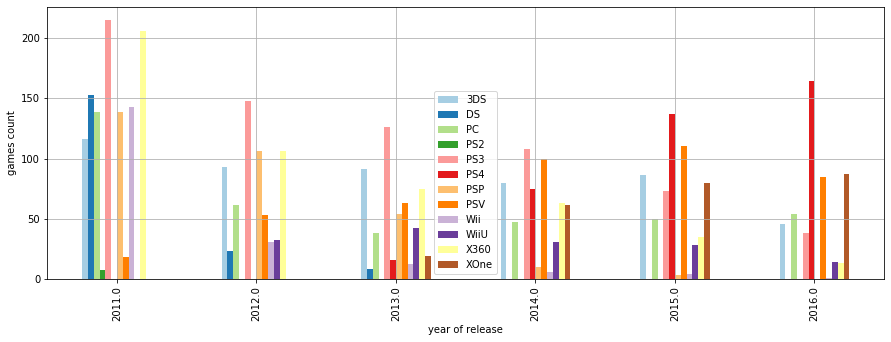

In [23]:
platform_by_year.plot(figsize=(15, 5), kind='bar', grid=True, colormap="Paired")
plt.xlabel('year of release')
plt.ylabel('games count')
plt.show()

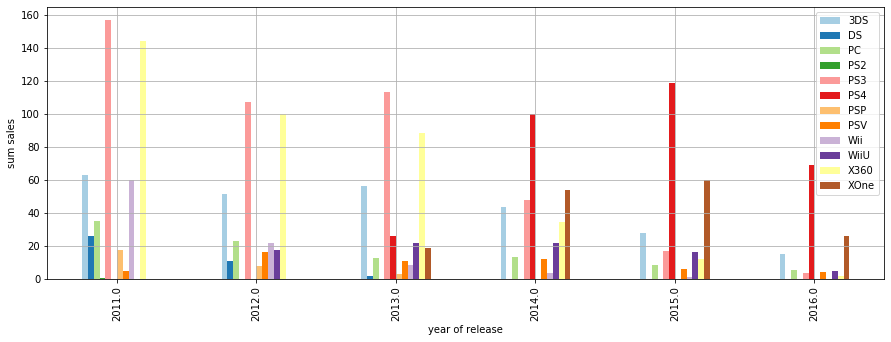

In [24]:
platform_by_year_revenue.plot(figsize=(15, 5), kind='bar', grid=True, colormap="Paired")
plt.xlabel('year of release')
plt.ylabel('sum sales')
plt.show()

**Вывод**

Набирают популярность стационарные платформы нового поколения - PS4, Xbox One. Количество выпускаемых игр для PC снижалось в 2013 году, но после 2014 года снова набирает популярность, однако суммарные продажи продолжают падать.

Суммарные продажи игр портативных консолей последнего поколения, таких как WiiU и PS Vita снижается к 2016 году.

### Глобальные продажи по платформам <a id="global_platform"></a>

In [25]:
platform_revenue = df_actual.pivot_table(index='platform', \
                                 values = 'sum_sales', aggfunc='sum').sort_values(\
                                        by = 'sum_sales', ascending = False)
platform_revenue = platform_revenue.head(7)
platform_revenue

,sum_sales
platform,
PS3,445.57
X360,380.38
PS4,314.14
3DS,257.81
XOne,159.32
PC,97.68
Wii,95.02


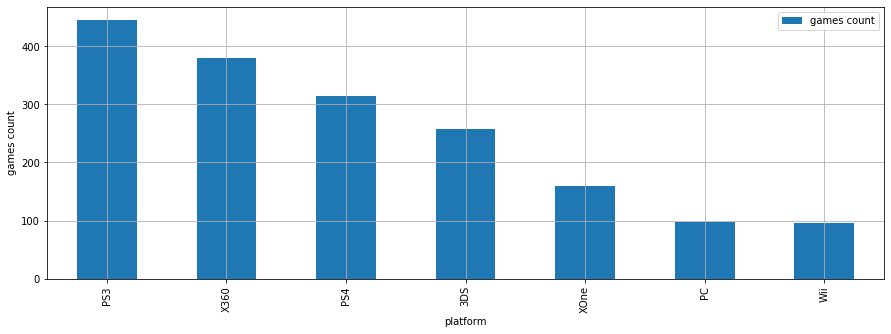

In [26]:
platform_revenue.plot(y='sum_sales', kind='bar', figsize=(15, 5), grid=True)
plt.legend(["games count"])
plt.xlabel('platform')
plt.ylabel('games count')
plt.show()

In [27]:
df_actual = df_actual.query('platform in @platform_revenue.index')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


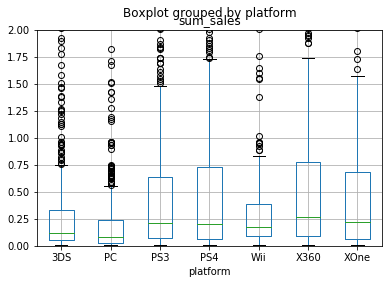

In [28]:
df_actual.boxplot("sum_sales", by="platform")
plt.ylim(0, 2)
plt.show()

**Вывод**

Самой прибыльной консолью является PS3, после нее Xbox 360. Данные платформы уже прошли пик своей популярности. Третья по прибыльности PS4 - новое поколение Playstation.

Портативная консоль 3DS самая прибыльная из семейства консолей Nintendo несмотря на то, что она вышла чуть раньше, чем WiiU которая провалилась в продажах. Предыдущее поколение Wii также является более прибыльным, чем WiiU.

Диаграммы размаха на всех актуальных консолях показывают, что стоимость большого количества игр выше медианной.

### Влияние отзывов пользователей и критиков на продажи в рамках платформы <a id="critics_plt"></a>

In [29]:
platform_review = df_actual.pivot_table(index='platform', values = ['critic_score', 'user_score'], aggfunc='mean')
platform_review = platform_review.merge(platform_revenue, on='platform', how='left')
platform_review.sort_values(by = 'sum_sales', ascending = False)

,critic_score,user_score,sum_sales
platform,,,
PS3,71.117479,6.612470,445.57
X360,69.831081,6.331594,380.38
PS4,72.091270,6.748249,314.14
3DS,67.156627,6.852047,257.81
XOne,73.325444,6.521429,159.32
PC,74.851211,6.451792,97.68
Wii,67.583333,6.575000,95.02


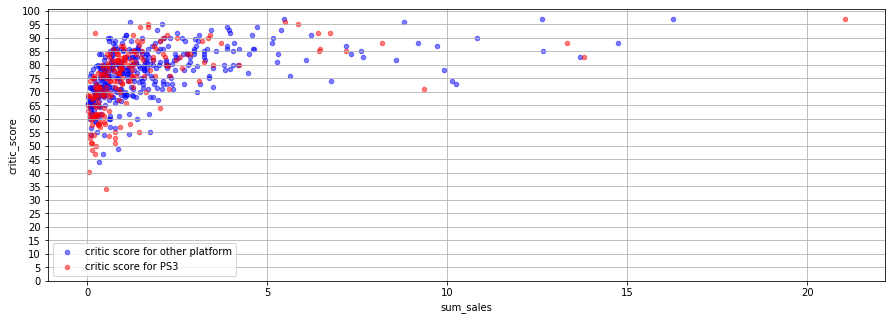

In [30]:
ax = df_actual.query('platform != "PS3"').pivot_table(index='sum_sales', values='critic_score', aggfunc='mean').reset_index()\
                     .plot(x='sum_sales', y='critic_score', figsize=(15, 5),\
                           kind='scatter', grid=True, color='Blue', alpha=0.5)
df_actual.query('platform == "PS3"').pivot_table(index='sum_sales', values='critic_score', aggfunc='mean').reset_index()\
                     .plot(x='sum_sales', y='critic_score', figsize=(15, 5),\
                           kind='scatter', grid=True, color='Red', alpha=0.5, ax=ax)

ax.legend(["critic score for other platform", "critic score for PS3"])
plt.yticks(np.arange(0,101,5))
plt.show()

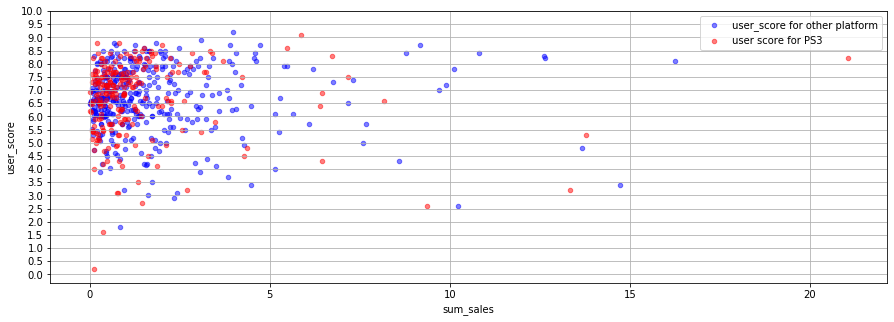

In [31]:
ax = df_actual.query('platform != "PS3"').pivot_table(index='sum_sales', values='user_score', aggfunc='mean').reset_index()\
                     .plot(x='sum_sales', y='user_score', figsize=(15, 5),\
                           kind='scatter', grid=True, color='Blue', alpha=0.5)
df_actual.query('platform == "PS3"').pivot_table(index='sum_sales', values='user_score', aggfunc='mean').reset_index()\
                     .plot(x='sum_sales', y='user_score', figsize=(15, 5),\
                           kind='scatter', grid=True, color='Red', alpha=0.5, ax=ax)
ax.legend(["user_score for other platform", "user score for PS3"])
plt.yticks(np.arange(0,10.5,0.5))
plt.show()

In [32]:
df_actual.loc[df_actual['sum_sales'].idxmax()]

name               Grand Theft Auto V
platform                          PS3
year_of_release                  2013
genre                          Action
na_sales                         7.02
eu_sales                         9.09
jp_sales                         0.98
other_sales                      3.96
critic_score                       97
user_score                        8.2
rating                              M
sum_sales                       21.05
Name: 0, dtype: object

In [33]:
df_actual['sum_sales'].corr(df_actual['critic_score'])

0.33836122289987736

In [34]:
df_actual['sum_sales'].corr(df_actual['user_score'])

0.031948225447757946

**Вывод**

Отзывы критиков имеют небольшое влияние на суммы продаж игр, в то время как отзывы пользователей не оказывают влияние.

Критики редко негативно отзываются об играх, менее 50 баллов из 100, но проекты, которые получили низкую оценку все же продаются хуже, чем игры с высоким баллом. Пользователи чаще ставят оценки ниже 5 из 10 баллов, но это в меньшей степени сказывается на продажах.

В рамках самой успешной с точки зрения количества проданных игр и продаж самой консоли PS3 ситуация такая же, как на остальных консолях. На PS3 вышла самый коммерчески успешный проект "Grand Theft Auto V", который был высоко оценен критиками: 97 баллов из 100.

### Распределение игр по жанрам <a id="genres"></a>

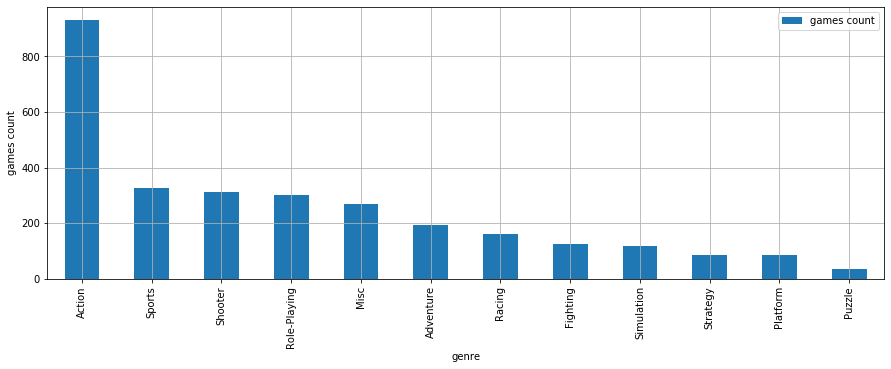

In [35]:
df_actual.groupby(['genre']).agg({'name':'count'}).sort_values(by = 'name', ascending = False\
                                                              ).plot(y='name', kind='bar', figsize=(15, 5), grid=True)
plt.legend(["games count"])
plt.xlabel('genre')
plt.ylabel('games count')
plt.show()

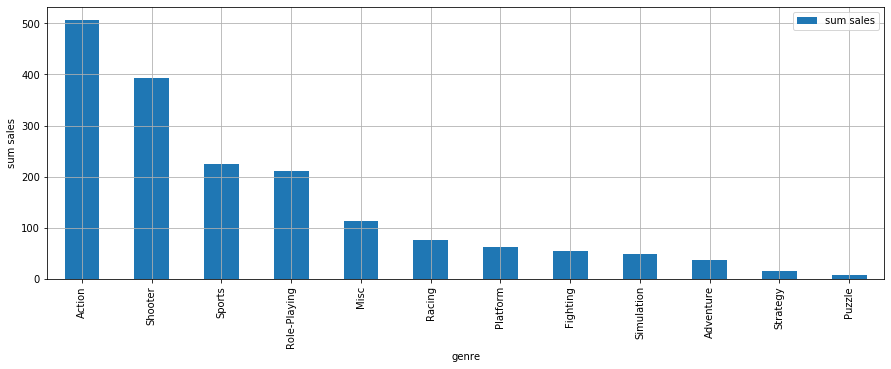

In [36]:
df_actual.groupby(['genre']).agg({'sum_sales':'sum'}).sort_values(by = 'sum_sales', ascending = False\
                                                              ).plot(y='sum_sales', kind='bar', figsize=(15, 5), grid=True)
plt.legend(["sum sales"])
plt.xlabel('genre')
plt.ylabel('sum sales')
plt.show()

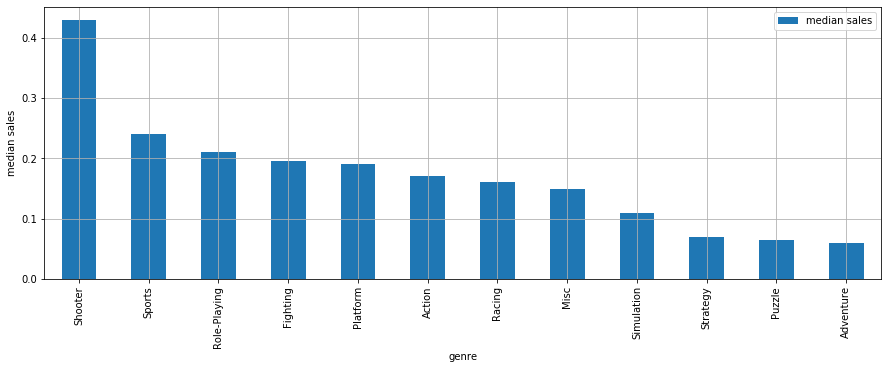

In [37]:
df_actual.groupby(['genre']).agg({'sum_sales':'median'}).sort_values(by = 'sum_sales', ascending = False\
                                                              ).plot(y='sum_sales', kind='bar', figsize=(15, 5), grid=True)
plt.legend(["median sales"])
plt.xlabel('genre')
plt.ylabel('median sales')
plt.show()

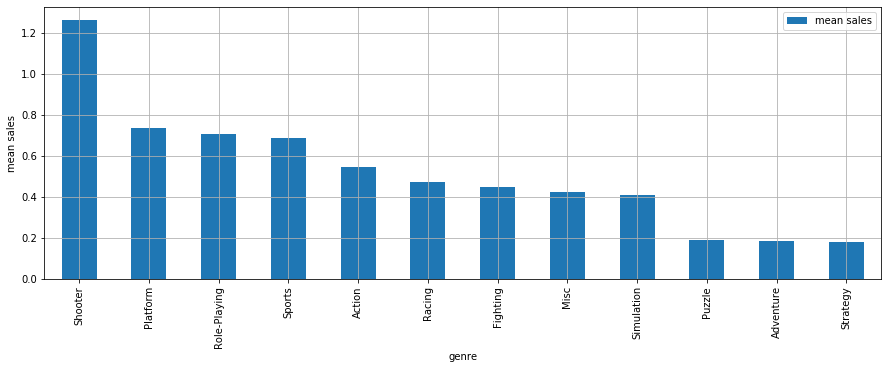

In [38]:
df_actual.groupby(['genre']).agg({'sum_sales':'mean'}).sort_values(by = 'sum_sales', ascending = False\
                                                              ).plot(y='sum_sales', kind='bar', figsize=(15, 5), grid=True)
plt.legend(["mean sales"])
plt.xlabel('genre')
plt.ylabel('mean sales')
plt.show()

**Вывод**

Самым популярным жанром является Action. Совокупная прибыль проектов сильно превышает сборы по остальным жанрам.

Средняя и медианная максимальная прибыль в рамках одного проекта в жанре Shooter.

Категории Sports и Role-Playing пользуются спросом у пользователей и имеют высокую среднюю и мединанную прибыльность.

В категориях Platform, Racing и Fighting выходит меньше проектов, чем в вышеуказанных, однако имеют достаточно высокую окупаемость в рамках проекта.

## Портрет пользователя каждого региона <a id="portrait"></a>

### Самые популярные платформы по регионам (топ-5) <a id="pop_plt5"></a>

In [39]:
top_5_platform = df_actual.groupby(['platform']\
    ).agg({'na_sales':'sum', 'eu_sales':'sum','jp_sales':'sum','other_sales':'sum'})
top_5_platform

,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
3DS,82.65,61.27,100.62,13.27
PC,29.88,56.70,0.00,11.10
PS3,168.26,163.10,49.39,64.82
PS4,108.74,141.09,15.96,48.35
Wii,48.56,29.60,8.97,7.89
X360,226.80,117.10,3.35,33.13
XOne,93.12,51.59,0.34,14.27


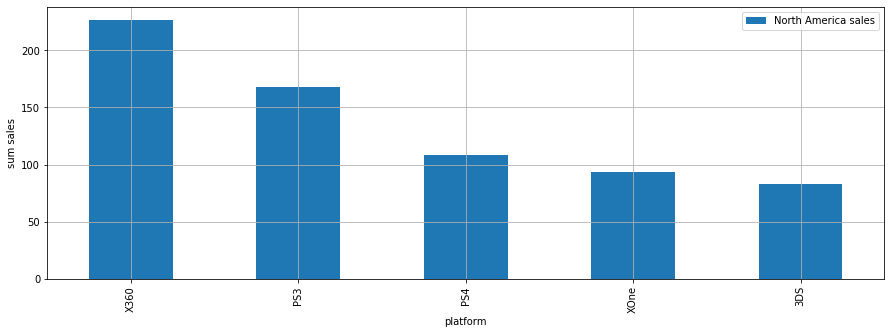

In [40]:
top_5_platform.sort_values(by = 'na_sales',ascending = False\
                          ).head().plot(y=['na_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["North America sales"])
plt.xlabel('platform')
plt.ylabel('sum sales')
plt.show()

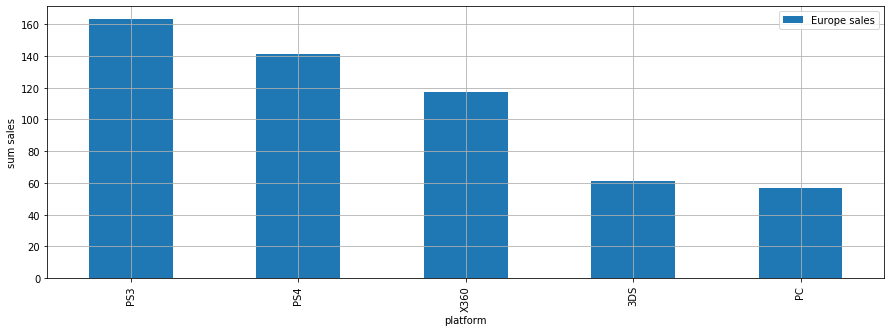

In [41]:
top_5_platform.sort_values(by = 'eu_sales',ascending = False\
                          ).head().plot(y=['eu_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["Europe sales"])
plt.xlabel('platform')
plt.ylabel('sum sales')
plt.show()

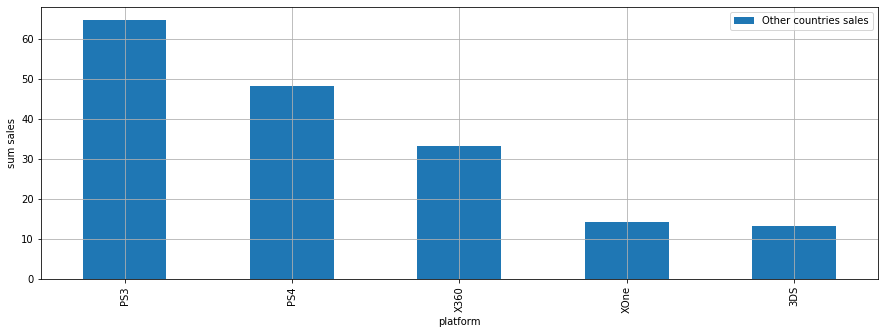

In [42]:
top_5_platform.sort_values(by = 'other_sales',ascending = False\
                          ).head().plot(y=['other_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["Other countries sales"])
plt.xlabel('platform')
plt.ylabel('sum sales')
plt.show()

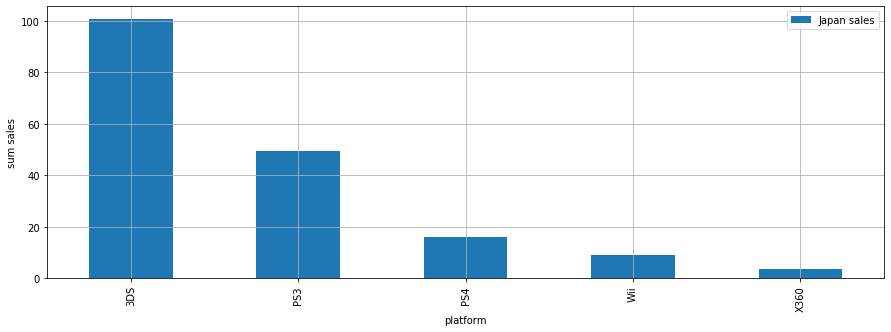

In [43]:
top_5_platform.sort_values(by = 'jp_sales',ascending = False\
                          ).head().plot(y=['jp_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["Japan sales"])
plt.xlabel('platform')
plt.ylabel('sum sales')
plt.show()

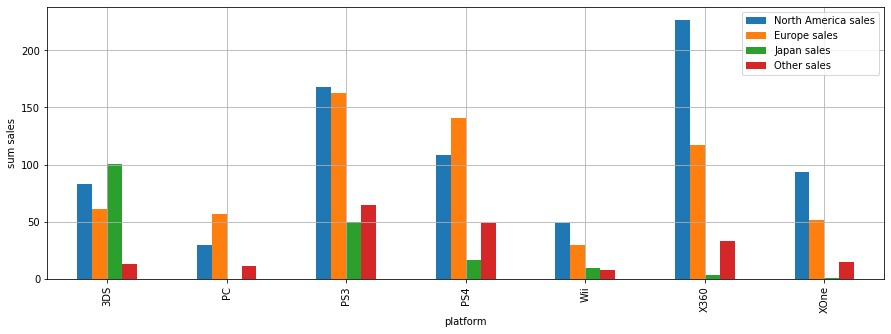

In [44]:
top_5_platform.plot(y=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'\
                                         ], kind='bar', figsize=(15, 5), grid=True, stacked=False)
plt.legend(["North America sales", "Europe sales", "Japan sales", "Other sales"])
plt.xlabel('platform')
plt.ylabel('sum sales')
plt.show()

**Вывод**

В Северной Америке наибольшая популярность у Xbox 360, в Европе и других странах у PS3, в Японии 3DS.

### Самые популярные жанры по регионам (топ-5) <a id="pop_genre5"></a>

In [45]:
top_5_genre = df_actual.groupby(['genre']\
    ).agg({'na_sales':'sum', 'eu_sales':'sum','jp_sales':'sum','other_sales':'sum'})
top_5_genre

,na_sales,eu_sales,jp_sales,other_sales
genre,,,,
Action,212.56,184.81,49.91,59.47
Adventure,13.70,13.11,5.28,3.83
Fighting,26.80,13.91,8.95,5.65
Misc,59.92,32.74,10.11,10.50
Platform,26.45,21.89,7.98,6.04
Puzzle,1.40,2.58,2.50,0.41
Racing,26.78,36.47,4.14,8.93
Role-Playing,76.73,58.31,58.77,17.97
Shooter,190.36,144.74,10.14,47.47


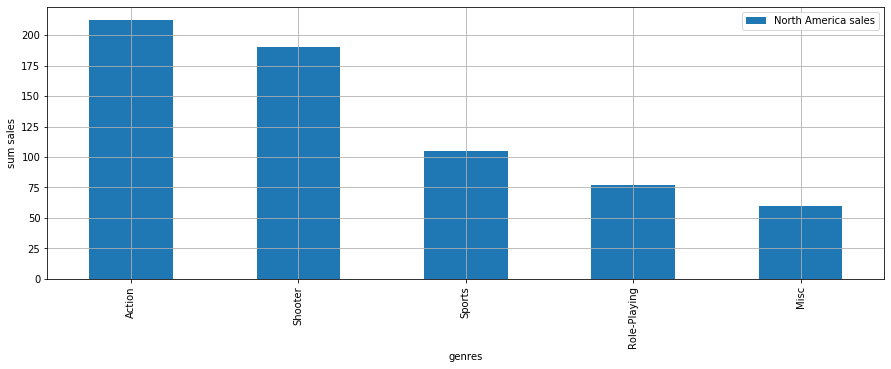

In [46]:
top_5_genre.sort_values(by = 'na_sales',ascending = False\
                          ).head().plot(y=['na_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["North America sales"])
plt.xlabel('genres')
plt.ylabel('sum sales')
plt.show()

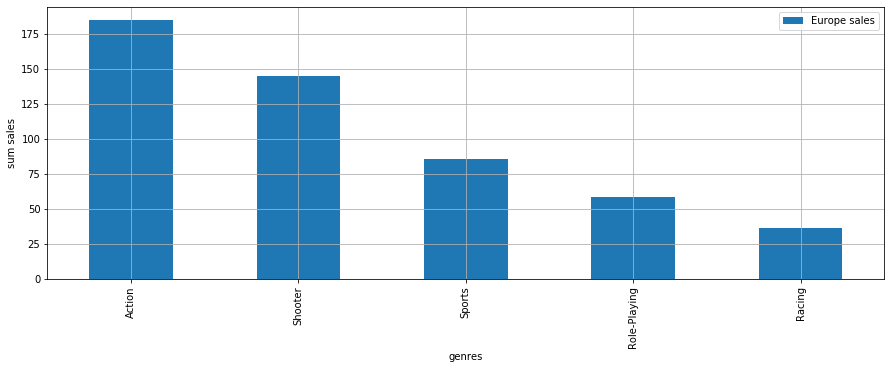

In [47]:
top_5_genre.sort_values(by = 'eu_sales',ascending = False\
                          ).head().plot(y=['eu_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["Europe sales"])
plt.xlabel('genres')
plt.ylabel('sum sales')
plt.show()

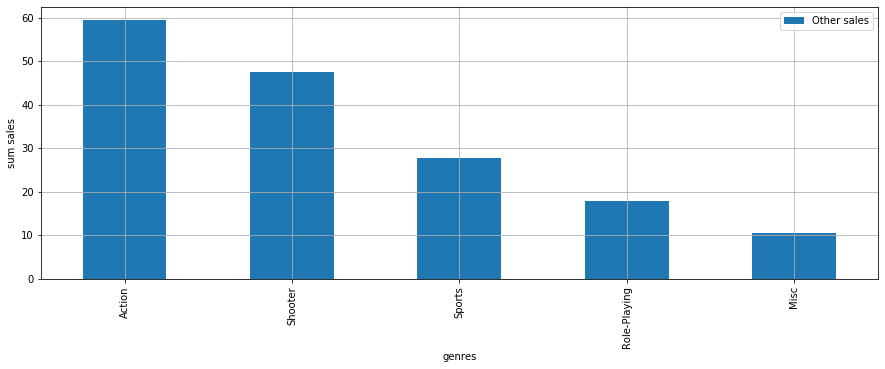

In [48]:
top_5_genre.sort_values(by = 'other_sales',ascending = False\
                          ).head().plot(y=['other_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["Other sales"])
plt.xlabel('genres')
plt.ylabel('sum sales')
plt.show()

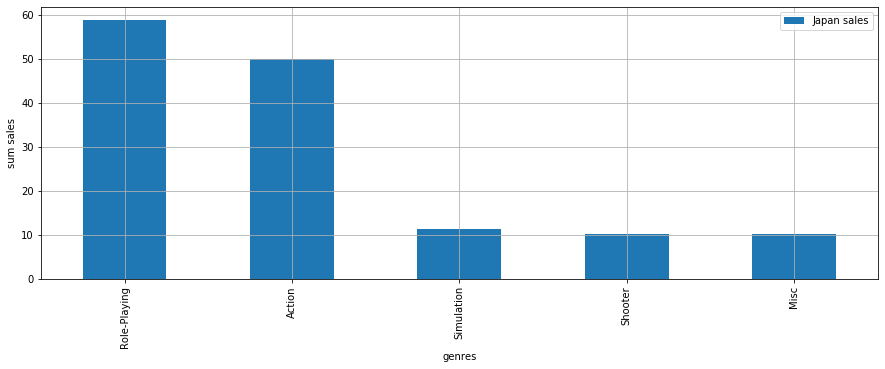

In [49]:
top_5_genre.sort_values(by = 'jp_sales',ascending = False\
                          ).head().plot(y=['jp_sales'], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["Japan sales"])
plt.xlabel('genres')
plt.ylabel('sum sales')
plt.show()

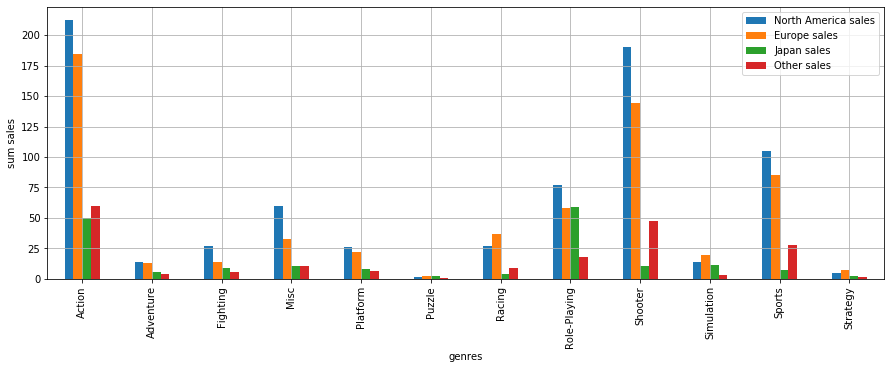

In [50]:
top_5_genre.plot(y=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'\
                                         ], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["North America sales", "Europe sales", "Japan sales", "Other sales"])
plt.xlabel('genres')
plt.ylabel('sum sales')
plt.show()

**Вывод**

Жанр Action самый популярный в Северной Америке, Европе и остальных странах. В Японии преобладает Role-Playing.

### Влияет ли рейтинг ESRB на продажи по регионам <a id="ESRB"></a>

In [51]:
rating = df_actual.groupby(['rating']\
    ).agg({'na_sales':'sum', 'eu_sales':'sum','jp_sales':'sum','other_sales':'sum'}\
                            ).sort_values(by = 'na_sales', ascending = False).head()
rating

,na_sales,eu_sales,jp_sales,other_sales
rating,,,,
M,302.69,246.12,23.86,80.00
E,143.36,124.44,27.96,35.80
without rating,107.97,105.63,93.33,30.40
T,102.92,78.64,25.61,26.12
E10+,101.07,65.59,7.87,20.50


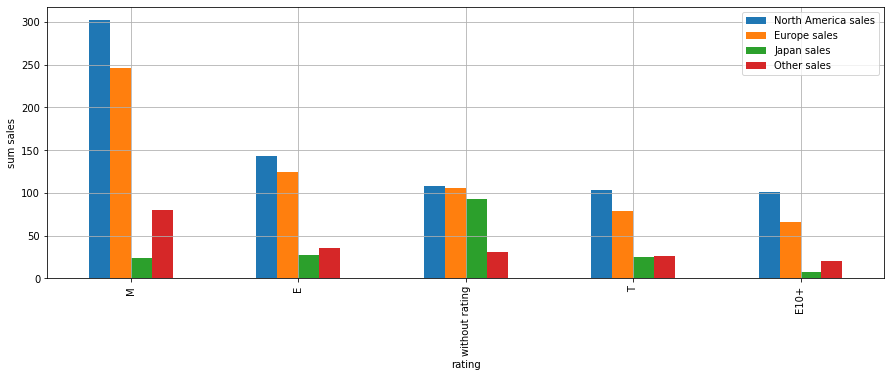

In [52]:
rating.plot(y=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'\
                                         ], kind='bar', figsize=(15, 5), grid=True)
plt.legend(["North America sales", "Europe sales", "Japan sales", "Other sales"])
plt.xlabel('rating')
plt.ylabel('sum sales')
plt.show()

**Вывод**

Cамые популярные игры в Северной Америке, Европе и остальных странах имеют рейтинг "Для взрослых". Категория подразумевает, что  проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

В Японии преобладает наибольшим спросом пользуются игры без рейтинга. Так как ESRB преимущественно работает с рынком США и Канады проекты, направленные на Японский рынок вероятно не заинтересованы в получении рейтинга.

## Проверка гипотез <a id="hypothesis"></a>

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a id="XONEPC"></a>

Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Критический уровень статистической значимости 0.05

In [53]:
user_score_XOne = df_actual[df_actual['platform'] == "XOne"]['user_score'].reset_index(drop=True)
user_score_PC = df_actual[df_actual['platform'] == "PC"]['user_score'].reset_index(drop=True)
print(user_score_XOne.count())
print(user_score_PC.count())

182
307


In [54]:
user_score_XOne.dropna(inplace = True) #удаляю пропущенные значения, так как с ними не обрабатываются тесты
user_score_PC.dropna(inplace = True)
print(user_score_XOne.isna().sum())
print(user_score_PC.isna().sum())

0
0


In [55]:
st.levene(user_score_XOne, user_score_PC, center='mean')

LeveneResult(statistic=7.5350679709363915, pvalue=0.006274578672320197)

In [56]:
alpha = 0.05

results = st.ttest_ind(user_score_XOne, user_score_PC, equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6267613081318799
Не получилось отвергнуть нулевую гипотезу


In [57]:
print('Средний пользовательский рейтинг для Xbox One:', user_score_XOne.mean())
print('Средний пользовательский рейтинг для PC:', user_score_PC.mean())

Средний пользовательский рейтинг для Xbox One: 6.521428
Средний пользовательский рейтинг для PC: 6.4517913


**Вывод**

Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые подтверждается.

Средний пользовательский рейтинг для Xbox One: 6.521428

Средний пользовательский рейтинг для PC: 6.4517913

### Средние пользовательские рейтинги жанров Action и Sports одинаковые <a id="ACSP"></a>

Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports отличаются.

Критический уровень статистической значимости 0.05

In [58]:
user_score_action = df_actual[df_actual['genre'] == "Action"]['user_score'].reset_index(drop=True)
user_score_sports = df_actual[df_actual['genre'] == "Sports"]['user_score'].reset_index(drop=True)
print(user_score_action.count())
print(user_score_sports.count())

564
226


In [59]:
user_score_action.dropna(inplace = True)
user_score_sports.dropna(inplace = True)
print(user_score_action.isna().sum())
print(user_score_sports.isna().sum())

0
0


In [60]:
st.levene(user_score_action, user_score_sports, center='mean')

LeveneResult(statistic=16.57911879042638, pvalue=5.137378741781973e-05)

In [61]:
alpha = 0.05

results = st.ttest_ind(user_score_action, user_score_sports, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.5114170665062098e-17
Отвергаем нулевую гипотезу


In [62]:
print('Средний пользовательский рейтинг для жанра Action:', user_score_action.mean())
print('Средний пользовательский рейтинг для жанра Sports:', user_score_sports.mean())

Средний пользовательский рейтинг для жанра Action: 6.7345743
Средний пользовательский рейтинг для жанра Sports: 5.6221237


**Вывод**

Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые отвергается. Игры категории Sports оцениваются пользователями ниже, чем игры в категории Action.

Средний пользовательский рейтинг для жанра Action: 6.7345743

Средний пользовательский рейтинг для жанра Sports: 5.6221237

## Общий вывод <a id="conc"></a>

Самыми актуальными консолями являются PS4 и Xbox One, выпущенные в 2013 году и набирающие популярность. Также стоит обратить внимание на игры для PC, так как данная платформа является в отличие от консолей не имеет четкой версионности и несмотря на растущие требования игр с точки зрения комплектующих для ПК игры маркируются общими системными требованиями.

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Популярность портативных консолей, таких как Wii, WiiU, PS Vita и 3DS снижается к 2016 году, также, как и популярность стационарных консолей прошлого поколения (PS3 и Xbox 360).

В Японии 3DS сохраняет популярность. 

Средний срок жизни консоли - 11 лет. 

Самым популярным и часто выпускаемым жанром является Action. Совокупная прибыль проектов сильно превышает сборы по остальным жанрам. Средняя и медианная максимальная прибыль в рамках одного проекта в жанрах Shooter, Sports и Role-Playing.

В категориях Platform, Racing и Fighting выходит меньшее число проектов, чем в вышеуказанных, однако они имеют достаточно высокую окупаемость в рамках проекта.

В Японии преобладает на жанр Role-Playing, Action и Simulator, который не входит в топ-5 остальных стран.

Отзывы критиков имеют небольшое влияние на суммы продаж игр, в то время как отзывы пользователей не оказывают влияние. Стоит учитывать, что критики редко негативно отзываются об играх, менее 50 баллов из 100, но проекты, которые получили низкую оценку все же продаются хуже, чем игры с высоким баллом. Пользователи чаще ставят оценки ниже 5 из 10 баллов, но это в меньшей степени сказывается на продажах.

Cамые популярные игры в Северной Америке, Европе и остальных странах имеют рейтинг "Для взрослых". 

В Японии преобладает наибольшим спросом пользуются игры без рейтинга. Так как ESRB преимущественно работает с рынком США и Канады проекты, направленные на Японский рынок вероятно не заинтересованы в получении рейтинга.
